# 95-869: Big Data and Large-Scale Computing Homework 5
# Michael G Turner


## **Yelp Dataset Assignment**

This project delves into exploratory analysis and building predictive models using the [Yelp academic dataset](https://www.yelp.com/dataset_challenge/). It is an opportunity for you to explore machine learning tasks in the context of a real-world data set using big data analysis tools. In order to use the dataset and finish this project, you must agree to the dataset's terms of use provided [here](https://www.yelp.com/html/pdf/Dataset_Challenge_Academic_Dataset_Agreement.pdf).

We have chosen a subset of the Yelp academic dataset for you to work with. This subsampled data is loaded into RDDs in part (0). The complete dataset is available from Yelp's website [here](https://www.yelp.com/dataset_challenge/dataset).

#### ** This assignment will cover: **
*  *Part 1 :* Exploratory Data Analysis [Link](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) [Link](https://spark.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#module-pyspark.mllib.stat)
*  *Part 2:* Prediction using tree ensemble methods [Link](https://spark.apache.org/docs/2.2.0/mllib-ensembles.html)
*  *Part 3:* Collaborative filtering for recommendation [Link](https://spark.apache.org/docs/2.2.0/mllib-collaborative-filtering.html)
*  *Part 4:* Word2Vec for text reviews [Link](https://park.apache.org/docs/2.2.0/api/python/pyspark.mllib.html#pyspark.mllib.feature.Word2Vec)
*  *Part 5 :* Frequent pattern mining using FP-Growth algorithm [Link](https://spark.apache.org/docs/2.2.0/mllib-frequent-pattern-mining.html)


#### Note that, for reference, you can look up the details of the relevant Spark methods in [Spark's Python API](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD) and the relevant NumPy methods in the [NumPy Reference](http://docs.scipy.org/doc/numpy/reference/index.html)

# ** Part 0: Load the datasets required for the project **

We will load four datasets for this project. In addition to the four datasets, we will also load two lists which contain names by gender. These lists are helpful in assigning a gender to a Yelp user by their name, since gender is not available in the Yelp dataset.

Let's first start by creating the SparkContext.

In [1]:
import sys
sys.path.append("/opt/packages/spark/latest/python/lib/py4j-0.10.4-src.zip")
sys.path.append("/opt/packages/spark/latest/python/")
sys.path.append("/opt/packages/spark/latest/python/pyspark")
from pyspark import SparkConf, SparkContext
sc = SparkContext()
sc

<SparkContext master=local[*] appName=pyspark-shell>

In [2]:
import json
import os
import sys
import os.path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

# helper function to load a JSON dataset from a publicly accessible url
def get_rdd_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    json_contents = [json.loads(x.strip()) for x in str_contents]
    rdd = sc.parallelize(json_contents)
    return rdd

The first dataset we are going to load is information about Yelp businesses. The information of each business will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

* "business_id":"encrypted business id"
* "name":"business name"
* "neighborhood":"hood name"
* "address":"full address"
* "city":"city"
* "state":"state -- if applicable --"
* "postal code":"postal code"
* "latitude":latitude
* "longitude":longitude
* "stars":star rating, rounded to half-stars
* "review_count":number of reviews
* "is_open":0/1 (closed/open)
* "attributes":["an array of strings: each array element is an attribute"]
* "categories":["an array of strings of business categories"]
* "hours":["an array of strings of business hours"]
* "type": "business"

In [133]:
# load the data about Yelp businesses in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
businesses_rdd = get_rdd_from_path('/pylon5/ci5619p/ahmaurya/yelp_academic_dataset_business.json')
print (businesses_rdd.count())
print (businesses_rdd.take(2))

61184
[{'business_id': 'vcNAWiLM4dR7D2nwwJ7nCA', 'full_address': '4840 E Indian School Rd\nSte 101\nPhoenix, AZ 85018', 'hours': {'Tuesday': {'close': '17:00', 'open': '08:00'}, 'Friday': {'close': '17:00', 'open': '08:00'}, 'Monday': {'close': '17:00', 'open': '08:00'}, 'Wednesday': {'close': '17:00', 'open': '08:00'}, 'Thursday': {'close': '17:00', 'open': '08:00'}}, 'open': True, 'categories': ['Doctors', 'Health & Medical'], 'city': 'Phoenix', 'review_count': 9, 'name': 'Eric Goldberg, MD', 'neighborhoods': [], 'longitude': -111.983758, 'state': 'AZ', 'stars': 3.5, 'latitude': 33.499313, 'attributes': {'By Appointment Only': True}, 'type': 'business'}, {'business_id': 'UsFtqoBl7naz8AVUBZMjQQ', 'full_address': '202 McClure St\nDravosburg, PA 15034', 'hours': {}, 'open': True, 'categories': ['Nightlife'], 'city': 'Dravosburg', 'review_count': 4, 'name': "Clancy's Pub", 'neighborhoods': [], 'longitude': -79.88693, 'state': 'PA', 'stars': 3.5, 'latitude': 40.350519, 'attributes': {'Hap

The second dataset we are going to load is information about Yelp users. Each user's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "user_id":"encrypted user id"
*  "name":"first name"
*  "review_count":number of reviews
*  "yelping_since": date formatted like "2009-12-19"
*  "friends":["an array of encrypted ids of friends"]
*  "useful":"number of useful votes sent by the user"
*  "funny":"number of funny votes sent by the user"
*  "cool":"number of cool votes sent by the user"
*  "fans":"number of fans the user has"
*  "elite":["an array of years the user was elite"]
*  "average_stars":floating point average like 4.31
*  "compliment_hot":number of hot compliments received by the user
*  "compliment_more":number of more compliments received by the user
*  "compliment_profile": number of profile compliments received by the user
*  "compliment_cute": number of cute compliments received by the user
*  "compliment_list": number of list compliments received by the user
*  "compliment_note": number of note compliments received by the user
*  "compliment_plain": number of plain compliments received by the user
*  "compliment_cool": number of cool compliments received by the user
*  "compliment_funny": number of funny compliments received by the user
*  "compliment_writer": number of writer compliments received by the user
*  "compliment_photos": number of photo compliments received by the user
*  "type":"user"

In [147]:
# load the data about Yelp users in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
users_rdd = get_rdd_from_path('/pylon5/ci5619p/ahmaurya/yelp_academic_dataset_user.json')
print (users_rdd.count())
print (users_rdd.take(2))

366715
[{'yelping_since': '2004-10', 'votes': {'funny': 166, 'useful': 278, 'cool': 245}, 'review_count': 108, 'name': 'Russel', 'user_id': '18kPq7GPye-YQ3LyKyAZPw', 'friends': ['rpOyqD_893cqmDAtJLbdog', '4U9kSBLuBDU391x6bxU-YA', 'fHtTaujcyKvXglE33Z5yIw', '8J4IIYcqBlFch8T90N923A', 'wy6l_zUo7SN0qrvNRWgySw', 'HDQixQ-WZEV0LVPJlIGQeQ', 'T4kuUr_iJiywOPdyM7gTHQ', 'z_5D4XEIlGAPjG3Os9ix5A', 'i63u3SdbrLsP4FxiSKP0Zw', 'pnrGw4ciBXJ6U5QB2m0F5g', 'ytjCBxosVSqCOQ62c4KAxg', 'r5uiIxwJ-I-oHBkNY2Ha3Q', 'niWoSKswEbooJC_M7HMbGw', 'kwoxiKMyoYjB1wTCYAjYRg', '9A8OuP6XwLwnNb9ov3_Ncw', '27MmRg8LfbZXNEHkEnKSdA', 'Bn4sJUTtKFZQt0FKHF2Adw', 'uguXfIEpI65jSCH5MgUDgA', '6VZNGc2h2Bn-uyuEXgOt5g', 'AZ8CTtwr-4sGM2kZqF6qig', 'S742m-AuQicMSLDdErrLZQ', 'uGmQ6ab4iVpWn5m61VFhkQ', 'GJYJX4SujVj3BR8v2F9PDQ', '3shjifK-vZkIHciyy_KbYA', '4lc_H2Cf7CO0tCgyA3aSVQ', 'Tunkp_F1R_uFBJQTsDxD4g', 'B9pKfr27czBbCoAIircZdQ', 'pePGMO6EbDpbaZ7D2m6HIg', 'XRM8W6HUoXbrYKR3BCj9Rg', '8DqIWXsKXOipfduYEfFpNw', 'dvRVX54Z9f7Om51NsTRX1w', 'CM0saLQmk4oAB17

The third dataset we are going to load is information about business checkins reported by users on Yelp. Each checkin's information will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "checkin_info":["an array of check ins with the format day-hour:number of check ins from hour to hour+1"]
*  "business_id":"encrypted business id"
*  "type":"checkin"

In [5]:
# load the data about business checkins reported by users on Yelp in an RDD
# each RDD element is a Python dictionary parsed from JSON using json.loads()
checkins_rdd = get_rdd_from_path('/pylon5/ci5619p/ahmaurya/yelp_academic_dataset_checkin.json')
print (checkins_rdd.count())
print (checkins_rdd.take(2))

45166
[{'checkin_info': {'9-5': 1, '7-5': 1, '13-3': 1, '17-6': 1, '13-0': 1, '17-3': 1, '10-0': 1, '18-4': 1, '14-6': 1}, 'type': 'checkin', 'business_id': 'cE27W9VPgO88Qxe4ol6y_g'}, {'checkin_info': {'22-5': 1, '9-5': 1, '15-1': 1, '15-4': 1, '16-2': 1, '21-4': 1, '13-1': 1, '14-4': 1, '12-5': 1, '12-1': 1}, 'type': 'checkin', 'business_id': 'mVHrayjG3uZ_RLHkLj-AMg'}]


The fourth dataset we are going to load is information about business reviews written by users on Yelp. Each review's data will be stored as a Python dictionary within an RDD. The dictionary consists of the following fields:

*  "review_id":"encrypted review id"
*  "user_id":"encrypted user id"
*  "business_id":"encrypted business id"
*  "stars":star rating rounded to half-stars
*  "date":"date formatted like 2009-12-19"
*  "text":"review text"
*  "useful":number of useful votes received
*  "funny":number of funny votes received
*  "cool": number of cool review votes received
*  "type": "review"

In [6]:
# load the data about business reviews written by users on Yelp in an RDD, limited to businesses in Pittsburgh due to DataBricks computational limits
# each RDD element is a Python dictionary parsed from JSON using json.loads()
reviews_rdd = get_rdd_from_path('/pylon5/ci5619p/ahmaurya/yelp_academic_dataset_review_pittsburgh.json')
print (reviews_rdd.count())
print (reviews_rdd.take(2))

62608
[{'votes': {'funny': 3, 'useful': 7, 'cool': 7}, 'user_id': 'JbAeIYc89Sk8SWmrBCJs9g', 'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww', 'stars': 5, 'date': '2013-06-10', 'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!", 'type': 'review', 'business_id': 'HZdLhv6COCleJMo7nPl-RA'}, {'votes': {'funny': 1, 'useful': 1, 'cool': 1}, 'user_id': 'l_szjd-ken3ma6oHDkTYXg', 'review_id': 'CFiLh7WvH7dM3qVZvNiacQ', 'stars': 2, '

Finally, we will load two lists. The first list consists of male names, and the second list consists of female names, to map Yelp user names to gender.

In [7]:
# helper function to load a list of names from a publicly accessible url
def get_names_from_path(path):
    file_reader = open(path, 'r')
    str_contents = file_reader.readlines()
    str_contents = [x.strip() for x in str_contents]
    result = str_contents[6:]
    return result

male_names = get_names_from_path('/pylon5/ci5619p/ahmaurya/male.txt')
print('First five male names: ', male_names[:5])
print('Number of male names: ', len(male_names))

female_names = get_names_from_path('/pylon5/ci5619p/ahmaurya/female.txt')
print('First five female names: ', female_names[:5])
print('Number of female names: ', len(female_names))

First five male names:  ['Aamir', 'Aaron', 'Abbey', 'Abbie', 'Abbot']
Number of male names:  2943
First five female names:  ['Abagael', 'Abagail', 'Abbe', 'Abbey', 'Abbi']
Number of female names:  5001


# ** Part 1: Exploratory Data Analysis **

Performing some exploratory analysis is a great step toward understanding the data before building any statistical machine learning models on it.

Please replace `<FILL IN>` with your solution. This is the general form that exercises will take. Exercises will include an explanation of what is expected, followed by code cells where one cell will have one or more `<FILL IN>` sections.  The cell that needs to be modified will have `# TODO: Replace <FILL IN> with appropriate code` on its first line.

In [8]:
print ('Number of businesses: ', businesses_rdd.count())
print ('Number of users: ', users_rdd.count())
print ('Number of checkins: ', checkins_rdd.count())
print ('Number of reviews: ', reviews_rdd.count())

Number of businesses:  61184
Number of users:  366715
Number of checkins:  45166
Number of reviews:  62608


** Question: ** Print the top 5 business categories by frequency and the number of times they appear in the businesses data.

In [9]:
#for reduce by key
from operator import add

#isolates catergoies, splits up, and appends 1 to each to enamble counting, then reduce by key
bizPair = businesses_rdd.flatMap(lambda x: (x['categories'])).map(lambda x: (x,1)).reduceByKey(add).collect()

#reads into data frame and sorts by frequency
bizPairOrderd = pd.DataFrame(bizPair)
bizPairOrderd.columns = ['catergory','count']
bizPairOrderd['frequency'] = bizPairOrderd['count']/sum(bizPairOrderd['count'])
bizPairOrderd = bizPairOrderd.sort_values(by=['frequency'], ascending=False)

#isolates the top five types of businesses
bizPairOrderd = bizPairOrderd.iloc[0:5,]
print(bizPairOrderd)

#features - by appointment only, busienss_id, catergories (list), city, full address, hours ,lat and long, name, etc.)

         catergory  count  frequency
468    Restaurants  21892   0.123896
72        Shopping   8919   0.050476
380           Food   7862   0.044494
633  Beauty & Spas   4738   0.026814
464      Nightlife   4340   0.024562


** Question: ** Print the top 5 cities by frequency and the number of times they appear in the businesses data.

In [10]:
# TODO: Replace <FILL IN>
#businesses_rdd.map(lambda x:x).take(1)

#isolates catergoies, splits up, and appends 1 to each to enamble counting, then reduce by key
bizPair = businesses_rdd.map(lambda x: (x['city'])).map(lambda x: (x,1)).reduceByKey(add).collect()

#reads into data frame and sorts by frequency
bizPairOrderd = pd.DataFrame(bizPair)
bizPairOrderd.columns = ['city','count']
bizPairOrderd['frequency'] = bizPairOrderd['count']/sum(bizPairOrderd['count'])
bizPairOrderd = bizPairOrderd.sort_values(by=['frequency'], ascending=False)
#isolates the top five types of businesses

#print(bizPairOrderd.shape)
bizPairOrderd = bizPairOrderd.iloc[0:5,]

print(bizPairOrderd)

           city  count  frequency
126   Las Vegas  13601   0.222297
184     Phoenix   8410   0.137454
226   Charlotte   4224   0.069038
86   Scottsdale   4039   0.066014
163   Edinburgh   3031   0.049539


** Question: ** Plot the histogram of stars received by businesses.

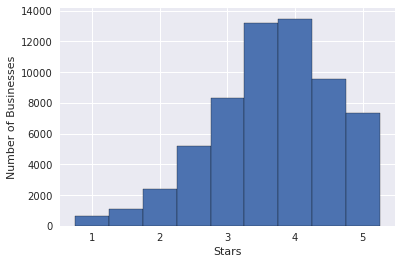

In [11]:
#collect the stars across all reviews
businesses_stars_counts = businesses_rdd.map(lambda x:x['stars']).collect() 

#Plots - add in edge color black to make more interptable
plt.hist(businesses_stars_counts, bins=[x/2-0.25 for x in range(2, 12)], edgecolor='black')
plt.xlabel('Stars')
plt.ylabel('Number of Businesses')

** Question: ** Plot the histogram of number of reviews received by businesses.

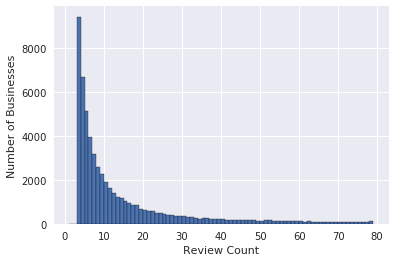

In [12]:
# TODO: Replace <FILL IN>
businesses_review_counts = businesses_rdd.map(lambda x:x['review_count']).collect() 

plt.hist(businesses_review_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Review Count')
plt.ylabel('Number of Businesses')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** I see a power law relationship.  The above plot is beveled in the middel, while the bottom plot has a linear trend; this is a visualization of a power law.

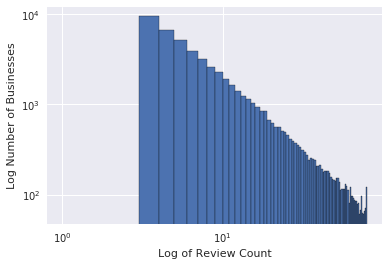

In [13]:
import math

#rebuilds
businesses_review_counts = businesses_rdd.map(lambda x:x['review_count']).collect()

#sets log
#businesses_review_counts  = [math.log(x) for x in businesses_review_counts]
#print(businesses_review_counts[1:10])

#sets bins
#binHolder = [math.log(x) for x in range(1,80)]
#print(binHolder)

#plots
plt.hist(businesses_review_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Log of Review Count')
plt.ylabel('Log Number of Businesses')
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposx='clip')

** Question: ** Plot the histogram of number of reviews written by users.

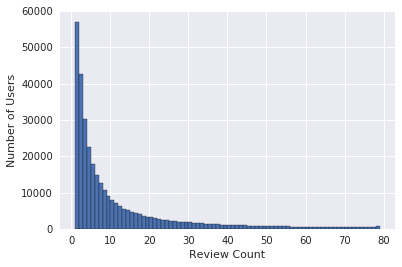

In [14]:
# TODO: Replace <FILL IN>

users_review_counts = users_rdd.map(lambda x: x['review_count']).collect()

plt.hist(users_review_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Review Count')
plt.ylabel('Number of Users')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** I see a power law relationship.  The above plot is beveled in the middel, while the bottom plot has a linear trend; this is a visualization of a power law.  Despite the noise at the tail end of the log-log chart the results are robust overall.

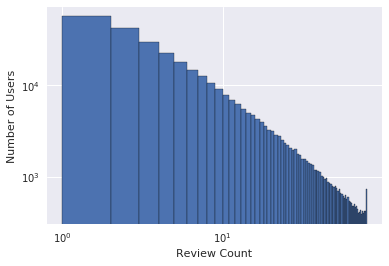

In [15]:
#find the counts
users_review_counts = users_rdd.map(lambda x: x['review_count']).collect()

#print(len(users_review_counts))

#zero isolator 
#zeroHolder = [x for x in users_review_counts if x==0]

#logs values counter
#users_review_counts = [math.log(x) for x in users_review_counts if x>0]

#summartion 
#users_review_counts = users_review_counts + zeroHolder
#print(len(users_review_counts))

plt.hist(users_review_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Review Count')
plt.ylabel('Number of Users')
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposx='clip')

** Question: ** Plot the histogram of number of friends a Yelp user has.

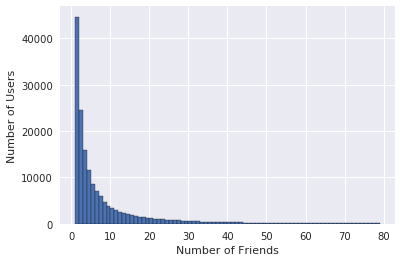

In [16]:
# TODO: Replace <FILL IN>
user_friend_counts = users_rdd.map(lambda x: len(x['friends'] )).collect()

plt.hist(user_friend_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** I see a power law relationship.  The above plot is beveled in the middel, while the bottom plot has a linear trend; this is a visualization of a power law.  Despite the noise at the tail end of the log-log chart the results are robust overall.

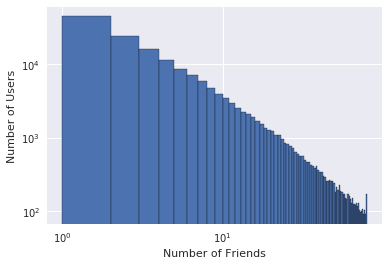

In [80]:
#finds values
user_friend_counts = users_rdd.map(lambda x: len(x['friends'] )).collect()
#print(len(user_friend_counts))

#zero isolator 
#zeroHolder = [x for x in user_friend_counts if x==0]

#logs values counter
#user_friend_counts = [math.log(x) for x in user_friend_counts if x>0]

#summartion 
#user_friend_counts = user_friend_counts + zeroHolder
#print(len(user_friend_counts))

#binholder
#binHolder = [math.log(x) for x in range(1,80)]

#plot
plt.hist(user_friend_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Number of Friends')
plt.ylabel('Number of Users')
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposx='clip')

** Question: ** Plot the histogram of number of fans a Yelp user has.

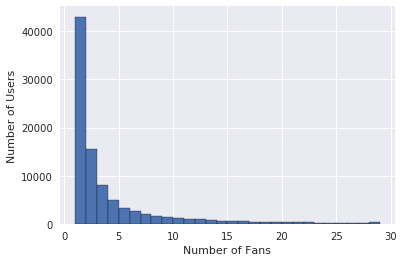

In [18]:
# TODO: Replace <FILL IN>

users_fan_counts = users_rdd.map(lambda x: (x['fans'])).collect()

plt.hist(users_fan_counts, bins=range(1,30), edgecolor='black')
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** I see a power law relationship.  The above plot is beveled in the middel, while the bottom plot has a linear trend; this is a visualization of a power law.  Despite the noise at the tail end of the log-log chart the results are robust overall.

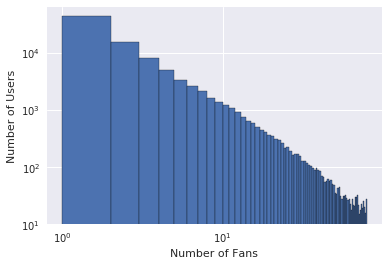

In [19]:
#finds values
user_friend_counts = users_rdd.map(lambda x: x['fans'] ).collect()
#print(len(user_friend_counts))

#zero isolator 
#zeroHolder = [x for x in user_friend_counts if x==0]

#logs values counter
#user_friend_counts = [math.log(x) for x in user_friend_counts if x>0]

#summartion 
#user_friend_counts = user_friend_counts + zeroHolder
#print(len(user_friend_counts))

#binholder
#binHolder = [math.log(x) for x in range(1,80)]

#plot
plt.hist(user_friend_counts, bins=range(1,80), edgecolor='black')
plt.xlabel('Number of Fans')
plt.ylabel('Number of Users')
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposx='clip')

** Question: ** Plot the histogram of number of checkins per Yelp business.

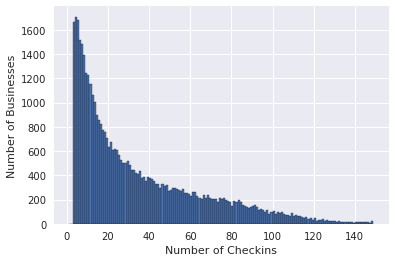

In [20]:
# TODO: Replace <FILL IN>

business_checkin_counts = checkins_rdd.map(lambda x: len(x['checkin_info'])).collect()

plt.hist(business_checkin_counts, bins=range(1,150), edgecolor='black')
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')

** Question: ** Plot the above histogram but now on a log-log scale. Do you see a [Power Law](https://en.wikipedia.org/wiki/Power_law) relationship in the plot? Explain your answer.

** Answer: ** I do not see a power law relationship in the case.  While the top plot has the bevel, the bottom chart does not have a linear trend like we were expecting.  Instead, its trend makes a more convex pattern.  This is a case where we do not see the power law.

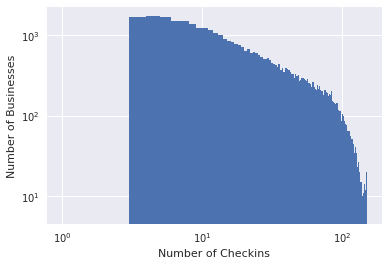

In [21]:
business_checkin_counts = checkins_rdd.map(lambda x: len(x['checkin_info'])).collect()

#print(len(business_checkin_counts))

#zero isolator 
#zeroHolder = [x for x in business_checkin_counts if x==0]

#logs values counter
#business_checkin_counts = [math.log(x) for x in business_checkin_counts if x>0]

#summartion 
#business_checkin_counts = business_checkin_counts + zeroHolder
#print(len(business_checkin_counts))

#binholder
#binHolder = [math.log(x) for x in range(1,150)]

plt.hist(business_checkin_counts, bins=range(1,150))
plt.xlabel('Number of Checkins')
plt.ylabel('Number of Businesses')
plt.xscale("log", nonposx='clip')
plt.yscale("log", nonposx='clip')

** Question: ** Find the maximum value of checkins per business. Filter to obtain business IDs of businesses that had these maximum number of checkins. Fill in the code required to carry out these steps.

In [22]:
# TODO: Replace <FILL IN>
#the total sum of all checkins for each business - per piazza

max_checkin_count = max(checkins_rdd.map(lambda x: sum(x['checkin_info'].values())).collect())
print(max_checkin_count)

business_ids_with_max_checkins = checkins_rdd \
    .filter(lambda x: sum(x['checkin_info'].values())==max_checkin_count) \
    .map(lambda x: x) \
    .collect()

#biz id holder
bisIDHolder = business_ids_with_max_checkins[0]['business_id']

#final response
len(business_ids_with_max_checkins)

62646


1

In [23]:
# TODO: Replace <FILL IN>
business_names_with_max_checkins = businesses_rdd \
    .filter(lambda x: x['business_id']==bisIDHolder) \
    .map(lambda x: (x['name'], x['city'])).collect()
business_names_with_max_checkins

[('McCarran International Airport', 'Las Vegas')]

** Question: ** Why do you think the above list sees much higher checkins than other businesses in the dataset?

** Answer: ** Las Vegas is by far the most popular city for yelp.  Airports are central hub where people all around the world go through the airport of Las Vegas, meaning it will get higher foot traffic than your typical store.  Combine these two factors and the numerous conferneces that Las Vegas hosts, it makes sense that the Airport is the number one.

** Question: ** Plot a histogram of the stars associated with business reviews.

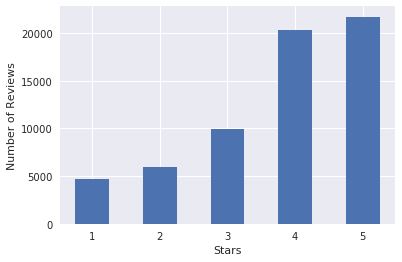

In [24]:
# TODO: Replace <FILL IN>

review_stars_counts = reviews_rdd.map(lambda x:x['stars']).collect()
plt.hist(review_stars_counts, bins=[x/2-0.25 for x in range(2, 12)])
plt.xlabel('Stars')
plt.ylabel('Number of Reviews')

** Question: ** Plot a histogram of the number of reviews written per Yelp user.

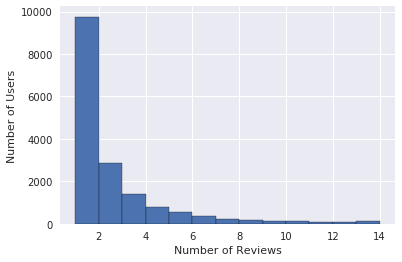

In [25]:
# TODO: Replace <FILL IN>

user_review_counts = list(reviews_rdd.map(lambda x: x['user_id']).countByValue().values())

plt.hist(user_review_counts, bins=[x for x in range(1, 15)], edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Users')

** Question: ** Plot a histogram of the number of reviews written per Yelp business.

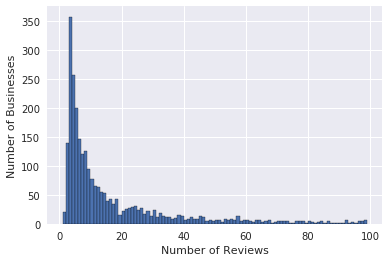

In [26]:
# TODO: Replace <FILL IN>

business_review_counts = list(reviews_rdd.map(lambda x:x['business_id']).countByValue().values())

plt.hist(business_review_counts, bins=[x for x in range(1, 100)], edgecolor='black')
plt.xlabel('Number of Reviews')
plt.ylabel('Number of Businesses')

** Question: ** Plot a histogram of the number of useful votes received by Yelp reviews.

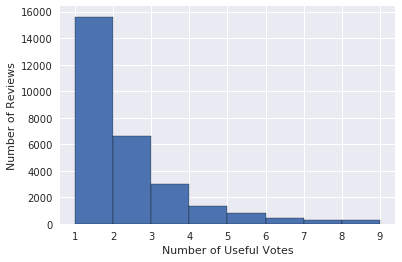

In [27]:
# TODO: Replace <FILL IN>

review_useful_counts = reviews_rdd.map(lambda x:x['votes']).map(lambda y: y['useful']).collect()

plt.hist(review_useful_counts, bins=[x for x in range(1, 10)], edgecolor='black')
plt.xlabel('Number of Useful Votes')
plt.ylabel('Number of Reviews')

** Question: ** Plot a histogram of the number of funny votes received by Yelp reviews.

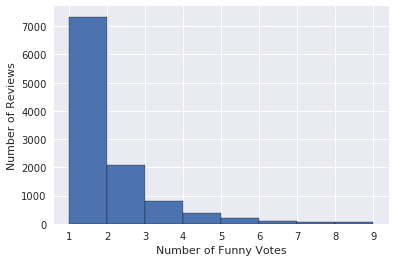

In [28]:
# TODO: Replace <FILL IN>

review_funny_counts = reviews_rdd.map(lambda x:x['votes']).map(lambda y: y['funny']).collect()

plt.hist(review_funny_counts, bins=[x for x in range(1, 10)], edgecolor='black')
plt.xlabel('Number of Funny Votes')
plt.ylabel('Number of Reviews')

** Question: ** Plot a histogram of the number of cool votes received by Yelp reviews.

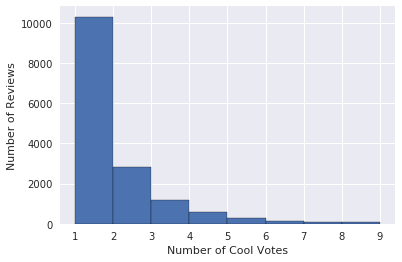

In [29]:
# TODO: Replace <FILL IN>

review_cool_counts = reviews_rdd.map(lambda x:x['votes']).map(lambda y: y['cool']).collect()

plt.hist(review_cool_counts, bins=[x for x in range(1, 10)], edgecolor='black')
plt.xlabel('Number of Cool Votes')
plt.ylabel('Number of Reviews')

** Question: ** Plot a pair-plot of the number of useful, funny, and cool votes received by Yelp reviews alongwith the stars associated with the review and the length of the review.

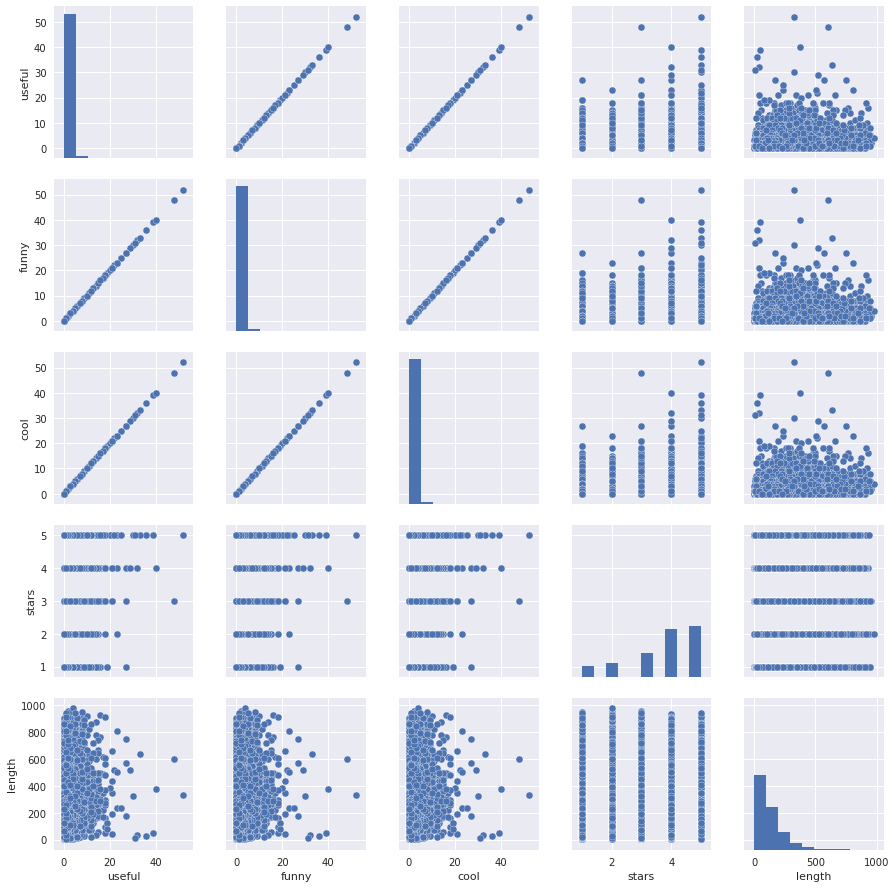

In [30]:
# TODO: Replace <FILL IN>
review_votes_length = reviews_rdd.map(lambda x: (x['votes']['useful'],x['votes']['useful'],x['votes']['useful'],x['stars'], len(x['text'].split()))).collect()
review_votes_length_df = pd.DataFrame(review_votes_length, columns=['useful', 'funny', 'cool', 'stars', 'length'])
sns.pairplot(review_votes_length_df)

** Question: ** Let us plot the distribution of the number of words used by males and females in their reviews. We will use the lists "male_names" and "female_names" we had created earlier for this purpose. Let's first find the user IDs associated with males and females.

In [31]:
# TODO: Replace <FILL IN>

male_users = users_rdd.filter(lambda x: x['name'] in male_names) 
female_users = users_rdd.filter(lambda x: x['name'] in female_names) 

male_user_ids = male_users.map(lambda x:x['user_id']).collect()
female_user_ids = female_users.map(lambda x:x['user_id']).collect()

print (len(male_user_ids))
print (len(female_user_ids))
print (users_rdd.count())

166682
174869
366715


** Question: ** We can now use the user ID lists to separate the reviews into those by males and females and calculate the length of each review.

In [32]:
# TODO: Replace <FILL IN>

male_reviews = reviews_rdd.filter(lambda x:x['user_id'] in male_user_ids).map(lambda x : x['text'])
female_reviews = reviews_rdd.filter(lambda x:x['user_id'] in female_user_ids).map(lambda x : x['text'])

male_word_count = male_reviews.map(lambda x: len(x.split()))
female_word_count = female_reviews.map(lambda x: len(x.split()))

print ('Male and female review length averages: ', male_word_count.mean(), female_word_count.mean())

Male and female review length averages:  127.34707879721354 139.21062276751064


** Question: ** The code below calculates the distributions of review lengths for males and female reviewers and plots them. Do you see a marked difference between the average review length of male and female reviewers? Are there any major trends or differences between the distributions of review length of male and female reviewers?

** Answer: ** Male review length averages at 127, while female review length averages at 139.  This is a marked difference of 12 words per review.  Overall, men have shorter reviews relative to women. We can see this because the peak of the womens review count is to the right of the blue peak (male) and because it is above the male line for the bulk of the higher review values.

In [33]:
male_word_distribution = list(male_word_count.map(lambda x : (x,1)).countByKey().items())
female_word_distribution = list(female_word_count.map(lambda x : (x,1)).countByKey().items())

male_word_distribution = sorted(male_word_distribution, key=lambda x: x[0])
female_word_distribution = sorted(female_word_distribution, key=lambda x: x[0])

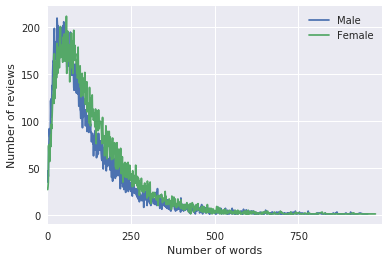

In [34]:
fig, ax = plt.subplots()
ax.plot([x[0] for x in male_word_distribution], [x[1] for x in male_word_distribution], label = 'Male')
ax.plot([x[0] for x in female_word_distribution], [x[1] for x in female_word_distribution], label = 'Female')

ax.set_xlim((0, 1000))
ax.set_xticks([0, 250, 500, 750])
ax.set_xticklabels(['0', '250','500','750'])

plt.xlabel('Number of words')
plt.ylabel('Number of reviews')
plt.legend()

# ** Part 2: Classification using tree ensemble methods **

In this section, we will predict the number of funny votes that a review has earned, indicating how funny readers found the review.

In [35]:
from pyspark.mllib.tree import DecisionTree, DecisionTreeModel
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.linalg import Vectors, DenseVector, SparseVector
from pyspark.mllib.regression import LabeledPoint

In [36]:
import re

#remove punctation
def removePunctuation(text):
    text = text.lower()
    text = re.sub('[^a-zA-Z0-9 ]', '', text)
    text = text.strip()
    return(text)

** Question: ** Fill in the necessary code to calculate word counts from text reviews below.

In [45]:
# TODO: Replace <FILL IN>
#frAbhinav Maurya 1 day ago Yes, it is an acceptable solution. The issue may be caused by multiple people using the same nodes. I didn't run into issues when I ran the  solution with 50000 features
max_words = 10000

all_reviews = reviews_rdd.map(lambda x : (removePunctuation(x['text']).split(), x['votes']['funny']))
word_counts = list(all_reviews.flatMap(lambda x:x[0]).map(lambda x: (x,1)).countByKey().items())
word_counts = sorted(word_counts, key=lambda x: -x[1])

unique_words = [x[0] for x in word_counts[:max_words]]
num_unique_words = len(unique_words)
print('Number of unique words: ', num_unique_words)
mostCommonWord = word_counts[0]

Number of unique words:  10000


** Question: ** We will now construct two dictionaries - one which maps from each word to a unique integer index and the second one which maps back from the index to the word. Write the code required to do this.

In [46]:
# TODO: Replace <FILL IN>

word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}

** Question: ** Fill in the required code below to obtain a LabeledPoint RDD that can be used to train an mllib classifier/regressor.

In [47]:
#experimental 
lister = [1,2,3,4,5,5,5,5,5,5]
listerUnique = list(set(lister))
listerUnique

#builds function to generate sparse vectors 
def SparseVectorBuilder(x1):
    x1 = sorted(list(x1))
    x1Unique = list(set(x1))
    x1Counter = [x1.count(x) for x in x1Unique]
    return(SparseVector(num_unique_words, [(x1Unique[x],x1Counter[x]) for x in range(0,len(x1Unique))]))

(SparseVectorBuilder(lister))
 
#return(SparseVector(numOHEFeats, [(OHEDict[(key,value)],1) for (key,value) in rawFeats if (key,value) in OHEDict]))
    

SparseVector(10000, {1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 6.0})

In [48]:
doc_vectors = all_reviews.map(lambda x: (x[1], x[0])).map(lambda x: (x[0], [word_to_index_dict[w] for w in x[1] if w in word_to_index_dict]))
doc_vectors = doc_vectors.map(lambda x:LabeledPoint(x[0], SparseVectorBuilder(list(x[1]))))
print(doc_vectors.count())
print(doc_vectors.take(2))

62608
[LabeledPoint(3.0, (10000,[0,1,2,3,4,6,9,10,11,12,14,15,16,17,22,25,34,39,42,46,54,55,61,84,94,107,113,126,163,166,203,205,276,305,347,348,389,406,420,490,501,567,595,628,637,682,734,750,781,826,879,882,1012,1071,1652,1701,2075,2538,2954,3035,3102,3131,3308,3353,3434,4179,4355,4947,6696,7882,9124,9533],[8.0,3.0,1.0,5.0,5.0,5.0,1.0,1.0,1.0,2.0,6.0,5.0,1.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,3.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0])), LabeledPoint(1.0, (10000,[0,4,5,8,9,10,16,17,27,35,44,49,51,60,61,70,92,95,134,194,206,239,276,307,322,353,420,435,567,643,717,726,826,2075,2789,3371,3940,4484,6460,6537,7222],[2.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0]))]


** Question: ** Randomly split the doc_vectors RDD into 80% training and 20% validation data.

In [50]:
# TODO: Replace <FILL IN>
weights = [.8, .2]
seed = 42
# Use randomSplit with weights and seed
#rawTrainData, rawValidationData, rawTestData = rawData.randomSplit(weights,seed)

doc_vectors_train, doc_vectors_val = doc_vectors.randomSplit(weights)
#doc_vectors_train.count() + doc_vectors_val.count() - doc_vectors.count()

** Question: ** Let us implement the baseline predictor which always outputs the most common value of funny votes. Fill in appropriate code.

In [52]:
# TODO: Replace <FILL IN>

most_common_prediction = doc_vectors_train.map(lambda x:x.label).mean()
labels_and_predictions = doc_vectors_val.map(lambda lp: (lp.label, most_common_prediction))
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Baseline) = ' + str(val_mse))
print('Learned baseline prediction: ', most_common_prediction)

Validation Root Mean Squared Error (Baseline) = 0.900159328252603
Learned baseline prediction:  0.3078762755102041


** Question: ** Let us now use a Decision Tree to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression.

In [53]:
# TODO: Replace <FILL IN>
#from ta : Abhinav Maurya 1 day ago Yes, it is an acceptable solution. The issue may be caused by multiple people using the same nodes. I didn't run into issues when I ran the  solution with 50000 features

#DecisionTree.trainRegressor(trainingData, categoricalFeaturesInfo, impurity,maxDepth, maxBins)
#variance is the default 
dt_model = DecisionTree.trainRegressor(doc_vectors_train, categoricalFeaturesInfo = {}, impurity ='variance', maxDepth=5, maxBins=16)

predictions = dt_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Decision Tree) = ' + str(val_mse))
print('Learned regression tree model:')
print(dt_model.toDebugString())

Validation Root Mean Squared Error (Decision Tree) = 0.8846120325797722
Learned regression tree model:
DecisionTreeModel regressor of depth 5 with 37 nodes
  If (feature 2 <= 6.0)
   If (feature 3 <= 5.0)
    If (feature 1684 <= 3.0)
     If (feature 3023 <= 2.0)
      If (feature 8741 <= 0.0)
       Predict: 0.20463299218664024
      Else (feature 8741 > 0.0)
       Predict: 7.25
     Else (feature 3023 > 2.0)
      If (feature 0 <= 2.0)
       Predict: 30.0
      Else (feature 0 > 2.0)
       Predict: 0.0
    Else (feature 1684 > 3.0)
     Predict: 17.0
   Else (feature 3 > 5.0)
    If (feature 2795 <= 1.0)
     If (feature 6424 <= 0.0)
      If (feature 7440 <= 1.0)
       Predict: 0.452738257649581
      Else (feature 7440 > 1.0)
       Predict: 13.0
     Else (feature 6424 > 0.0)
      If (feature 0 <= 5.0)
       Predict: 18.0
      Else (feature 0 > 5.0)
       Predict: 1.0
    Else (feature 2795 > 1.0)
     If (feature 0 <= 10.0)
      Predict: 20.0
     Else (feature 0 > 10.0)

** Question: ** Let us now use a Random Forest ensemble to predict the number of funny votes. Set the maximum depth of the tree to 5 and use an appropriate impurity metric for regression. Build a random forest regressor with 10 trees.

In [55]:
# TODO: Replace <FILL IN>

rf_model = RandomForest.trainRegressor(doc_vectors_train, categoricalFeaturesInfo ={}, numTrees = 10,impurity ='variance', maxDepth=5, maxBins=16)


predictions = rf_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Random Forest) = ' + str(val_mse))
print('Learned regression RF model:')
print(rf_model.toDebugString())

Validation Root Mean Squared Error (Random Forest) = 0.8785357728418769
Learned regression RF model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 292 <= 3.0)
     If (feature 2 <= 5.0)
      If (feature 7752 <= 0.0)
       If (feature 7601 <= 0.0)
        If (feature 7189 <= 0.0)
         Predict: 0.21999222092570983
        Else (feature 7189 > 0.0)
         Predict: 3.869565217391304
       Else (feature 7601 > 0.0)
        If (feature 39 <= 0.0)
         Predict: 1.5
        Else (feature 39 > 0.0)
         Predict: 32.0
      Else (feature 7752 > 0.0)
       If (feature 14 <= 1.0)
        Predict: 0.0
       Else (feature 14 > 1.0)
        Predict: 25.0
     Else (feature 2 > 5.0)
      If (feature 534 <= 3.0)
       If (feature 8130 <= 1.0)
        If (feature 17 <= 1.0)
         Predict: 0.435451607939683
        Else (feature 17 > 1.0)
         Predict: 0.7598297527361167
       Else (feature 8130 > 1.0)
        Predict: 9.0
      Else (feature 534 > 3.0)

** Question: ** Let us now use a Gradient Boosting Trees (GBT) ensemble to predict the number of funny votes. Set the maximum number of iterations to 10. Does this affect the number of trees in the ensemble? Do we need to set the maximum depth of trees in the ensemble? Why or why not?

** Answer: **  No this does not affect the number of trees in the ensemble nor do we need to set the maximum depth of trees.  In both cases since we are using Gradient Boosting Trees both are needless.  It boosts the results by looking at a variety of trees.  Since there area variety of trees, using more iterations tends to become redundant.  And since each tree takes a slighlty different set of the data the maximum depth of the tree is cut short by disagreeement between the models once confidence falls at deeper levels.  This is a smart tree model that makes itself better without these tuning concers.

In [79]:
# TODO: Replace <FILL IN>

gb_model = GradientBoostedTrees.trainRegressor(doc_vectors_train, categoricalFeaturesInfo ={}, numIterations = 10, maxDepth=5)

predictions = gb_model.predict(doc_vectors_val.map(lambda x: x.features))
labels_and_predictions = doc_vectors_val.map(lambda lp: lp.label).zip(predictions)
val_mse = labels_and_predictions.map(lambda lp: (lp[0] - lp[1]) * (lp[0] - lp[1])).sum() /\
    float(doc_vectors_val.count())
print('Validation Root Mean Squared Error (Gradient Boosting Trees) = ' + str(val_mse))
print('Learned regression GBT model:')
print(gb_model.toDebugString())

Validation Root Mean Squared Error (Gradient Boosting Trees) = 0.8805150044539354
Learned regression GBT model:
TreeEnsembleModel regressor with 10 trees

  Tree 0:
    If (feature 2 <= 6.0)
     If (feature 3 <= 5.0)
      If (feature 1684 <= 3.0)
       If (feature 3023 <= 2.0)
        If (feature 8741 <= 0.0)
         Predict: 0.20463299218664024
        Else (feature 8741 > 0.0)
         Predict: 7.25
       Else (feature 3023 > 2.0)
        If (feature 0 <= 2.0)
         Predict: 30.0
        Else (feature 0 > 2.0)
         Predict: 0.0
      Else (feature 1684 > 3.0)
       Predict: 17.0
     Else (feature 3 > 5.0)
      If (feature 2795 <= 1.0)
       If (feature 6424 <= 0.0)
        If (feature 7440 <= 1.0)
         Predict: 0.452738257649581
        Else (feature 7440 > 1.0)
         Predict: 13.0
       Else (feature 6424 > 0.0)
        If (feature 0 <= 5.0)
         Predict: 18.0
        Else (feature 0 > 5.0)
         Predict: 1.0
      Else (feature 2795 > 1.0)
       If (

** Question: ** Which of the four methods we tried gave the best validation RMSE results? 

** Answer: ** Random Forest

# ** Part 3: Collaborative filtering for recommendation **

In this section, we will tackle a [collaborative filtering](https://en.wikipedia.org/wiki/Collaborative_filtering) task which can be used to recommend businesses to users based on the ratings they have already assigned to some businesses they have visited.

In [58]:
from pyspark.mllib.recommendation import ALS, MatrixFactorizationModel, Rating

** Question: ** Let us first determine the unique user and business IDs that appear in the reviews data. This will help us build dictionaries for mapping the user/business IDs to unique integer indices. Fill in the required code to build these dictionaries below.

In [59]:
reviews_rdd.take(1)

[{'business_id': 'HZdLhv6COCleJMo7nPl-RA',
  'date': '2013-06-10',
  'review_id': 'fBQ69-NU9ZyTjjS7Tb5tww',
  'stars': 5,
  'text': "THANK YOU ROB! i truly appreciated all the help i received from this agent today who was able to removed the extra charges on my bill that the Pasadena Verizon Store on Lake was charging me on my bill for upgrading my phone.   When i went in i was having problems with my Blacberry and had to switch to the Iphone last week. Rob from the Pennsylvania store who i was connected today was able to look at my bill and all the notes and correct the problem immediately. Great Customer Service! He even set up a FOLLOW UP Phone Call with me On July 5th to make sure the credit goes through on my bill...I can't thank him enough!!!!",
  'type': 'review',
  'user_id': 'JbAeIYc89Sk8SWmrBCJs9g',
  'votes': {'cool': 7, 'funny': 3, 'useful': 7}}]

In [60]:
# TODO: Replace <FILL IN>

review_user_ids = reviews_rdd.map(lambda x:x['user_id']).collect()
review_business_ids = reviews_rdd.map(lambda x:x['business_id']).collect()

user_to_index_dict = {review_user_ids[i]:i for i in range(len(review_user_ids))}
business_to_index_dict = {review_business_ids[i]:i for i in range(len(review_business_ids))}

#word_to_index_dict = {unique_words[i]:i for i in range(len(unique_words))}
#index_to_word_dict = {i:unique_words[i] for i in range(len(unique_words))}
#user_to_index_dict['JbAeIYc89Sk8SWmrBCJs9g']

** Question: ** Next, transform each review into a rating. The Rating object takes a unique user index, a unique business index, and float-valued rating.

In [61]:
# TODO: Replace <FILL IN>

#ratings_rdd = reviews_rdd.map(lambda x: Rating(x['user_id'], x['business_id'], x['stars']))
ratings_rdd = reviews_rdd.map(lambda x: Rating(user_to_index_dict[x['user_id']], business_to_index_dict[x['business_id']], x['stars']))

print(ratings_rdd.take(2))

[Rating(user=0, product=2, rating=5.0), Rating(user=59244, product=2, rating=2.0)]


** Question: ** Let us randomly split data into 80% train and 20% validation set.

In [62]:
# TODO: Replace <FILL IN>

ratings_rdd_train, ratings_rdd_val = ratings_rdd.randomSplit(weights)

** Question: ** For a succession of ranks, we will now build an collaborative filtering algorithm using ALS (Alternating Least Squares). We will use the model to obtain train as well as validation RMSE for each rank. In the cell below, you can fill in the code to carry out the model-building, prediction, and RMSE calculation.

In [88]:
# TODO: Replace <FILL IN>

numIterations=10
ranks = list(range(1,20)) + list(range(20, 201, 20))
train_rmses = []
val_rmses = []

for rank in ranks:
    cf_model = ALS.train(ratings=ratings_rdd_train, rank = rank)
    
    train_data = ratings_rdd_train.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(train_data).map(lambda r: ((r[0], r[1]), r[2])) ###
    rates_and_preds = ratings_rdd_train.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    train_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    train_rmses.append(train_rmse)
    
    val_data = ratings_rdd_val.map(lambda p: (p[0], p[1]))
    predictions = cf_model.predictAll(val_data).map(lambda r: ((r[0], r[1]), r[2])) ###
    rates_and_preds = ratings_rdd_val.map(lambda r: ((r[0], r[1]), r[2])).join(predictions)
    val_rmse = np.sqrt(rates_and_preds.map(lambda r: (r[1][0] - r[1][1])**2).mean())
    val_rmses.append(val_rmse)
    
    print("Root Mean Squared Error (rank={}) = Train {}, Validation {}".format(rank, train_rmse, val_rmse))

Root Mean Squared Error (rank=1) = Train 2.8762812619290306, Validation 6.380941378741405
Root Mean Squared Error (rank=2) = Train 1.7132621567137847, Validation 5.287132697031285
Root Mean Squared Error (rank=3) = Train 1.3607165405484347, Validation 4.563600213975438
Root Mean Squared Error (rank=4) = Train 1.136833449215343, Validation 4.182412984122667
Root Mean Squared Error (rank=5) = Train 0.8257136263981804, Validation 3.589481725167764
Root Mean Squared Error (rank=6) = Train 0.6199101717419553, Validation 2.9666253695555875
Root Mean Squared Error (rank=7) = Train 0.6102694662728081, Validation 3.0161380280429
Root Mean Squared Error (rank=8) = Train 0.5037581201210064, Validation 2.745762137485656
Root Mean Squared Error (rank=9) = Train 0.45140966407993616, Validation 2.626105997584393
Root Mean Squared Error (rank=10) = Train 0.4414019953008402, Validation 2.7250039895331084
Root Mean Squared Error (rank=11) = Train 0.41614063369680493, Validation 2.7244380968273543
Root M

** Question: ** Let us plot the train and validation RMSE versus the rank. The code below does this for you. Based on this plot, what would your choice of the rank hyperparameter be? Is this choice conclusive or do we need to conduct a more extensive hyperparameter search at larger ranks than the ones we have evaluated?

** Answer: ** Based on the validation set I would choose a rank of 75.  Beyond this poing in the validation set the  RMSE plateus, indicating that despite increasing complexity there are no returns of scale.  75 would be the last threshold where there are gains with higher ranks.  We do not need to have a more extensive search of higher ranks, because there are no returns of scale beyond 75 as it is.  Results would likely be the same.

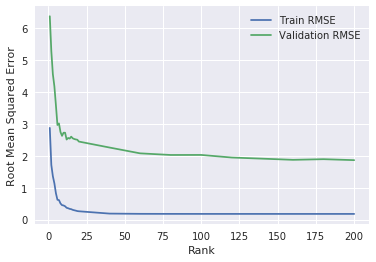

In [89]:
fig, ax = plt.subplots()
ax.plot(ranks, train_rmses, label='Train RMSE')
ax.plot(ranks, val_rmses, label='Validation RMSE')

plt.xlabel('Rank')
plt.ylabel('Root Mean Squared Error')
plt.legend()

# ** Part 4: Word2Vec for text reviews **

In this section, we will fit a [Word2Vec](https://en.wikipedia.org/wiki/Word2vec) model to the Yelp reviews text. Word2Vec is a popular model for embedding words in Euclidean space so they can be analyzed similar to real-valued vectors. Contrary to popular belief, Word2Vec models are not deep neural models. Inspite of being shallow neural networks, they capture word associations and analogies remarkably well. 

In [73]:
from pyspark.mllib.feature import Word2Vec
import re
pattern = re.compile('[\W_]+')

In [74]:
review_docs = reviews_rdd.map(lambda x : x['text'].lower().split())
review_docs = review_docs.map(lambda x : [pattern.sub('', w) for w in x])
print(review_docs.take(2))

[['thank', 'you', 'rob', 'i', 'truly', 'appreciated', 'all', 'the', 'help', 'i', 'received', 'from', 'this', 'agent', 'today', 'who', 'was', 'able', 'to', 'removed', 'the', 'extra', 'charges', 'on', 'my', 'bill', 'that', 'the', 'pasadena', 'verizon', 'store', 'on', 'lake', 'was', 'charging', 'me', 'on', 'my', 'bill', 'for', 'upgrading', 'my', 'phone', 'when', 'i', 'went', 'in', 'i', 'was', 'having', 'problems', 'with', 'my', 'blacberry', 'and', 'had', 'to', 'switch', 'to', 'the', 'iphone', 'last', 'week', 'rob', 'from', 'the', 'pennsylvania', 'store', 'who', 'i', 'was', 'connected', 'today', 'was', 'able', 'to', 'look', 'at', 'my', 'bill', 'and', 'all', 'the', 'notes', 'and', 'correct', 'the', 'problem', 'immediately', 'great', 'customer', 'service', 'he', 'even', 'set', 'up', 'a', 'follow', 'up', 'phone', 'call', 'with', 'me', 'on', 'july', '5th', 'to', 'make', 'sure', 'the', 'credit', 'goes', 'through', 'on', 'my', 'billi', 'cant', 'thank', 'him', 'enough'], ['after', 'waiting', 'for

** Question: ** Fit a Word2Vec model to the review_docs RDD. Set the size of embedding vectors to 10, the random seed to 42, and the number of iterations to 10.

In [77]:
# TODO: Replace <FILL IN>

word2vec_model = Word2Vec().setSeed(42).setVectorSize(10).fit(review_docs) #.setIterations(10)

Let's us examine what words are closely associated with some example words. Run the cell below to see word associations. Feel free to add any additional words whose results you find interesting, but do not delete any of the words already in the list.

In [78]:
for word in ['salt', 'pepper', 'restaurant', 'italian', 'indian', 'chinese', 'direction', 'pittsburgh', 'burgh', 'city', 'location', 'cmu', 'pizza']:
    syms = word2vec_model.findSynonyms(word, 5)
    print('Words most similar to ', word, ' : ', [s[0] for s in syms])

Words most similar to  salt  :  ['goodness', 'oats', 'golabki', 'singular', 'yuk']
Words most similar to  pepper  :  ['jalapenos', 'mayo', 'peppers', 'spear', 'brown']
Words most similar to  restaurant  :  ['location', 'establishment', 'particular', 'osteria', 'scene']
Words most similar to  italian  :  ['style', 'american', 'lebanese', 'greek', 'tuscany']
Words most similar to  indian  :  ['chinese', 'mexican', 'cuisine', 'asian', 'vietnamese']
Words most similar to  chinese  :  ['mexican', 'indian', 'asian', 'japanese', 'cuisine']
Words most similar to  direction  :  ['snuck', 'rip', 'charities', 'goals', 'connect']
Words most similar to  pittsburgh  :  ['pgh', 'nyc', 'oakland', 'shadyside', 'thailand']
Words most similar to  burgh  :  ['city', 'hiptique', 'strip', 'pa', 'favourite']
Words most similar to  city  :  ['burgh', 'pa', 'planet', 'willys', 'humble']
Words most similar to  location  :  ['scene', 'restaurant', 'neighborhood', 'cafe', 'establishment']
Words most similar to  c

** Question: ** What "synonyms" in the result above give rise to perfect analogies? Are there words in the result that are spurious and not good substitutes for the originally supplied word?

** Answer: ** 

Analogies
Restaurant -> establishment
italian -> tuscany
burgh  -> strip 
location -> scene

Not good subsitutes:
italian  > american , lebanese, greek
indian > chinese, mexican, 
chinese > mexican, indian, japanese
pittsburgh > nyc, thailand

These words are not good subsitutes, they in fact mean completly different things.  These occured because these words are used in similar contexts across all places and thus confused the machine learning process.

# ** Part 5: Frequent pattern mining using FP-Growth algorithm **

In this section, we will mine frequent subsets of items that appear together in datapoints. This type of analysis is also known as frequent itemset mining or market basket analysis. Since the tags associated with Yelp businesses are sets, we can use them to carry out the frequent item set mining by employing the FP-Growth algorithm available in Spark.

In [81]:
from pyspark.mllib.fpm import FPGrowth

** Question: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.01 and 10 partitions.

In [214]:
# TODO: Replace <FILL IN>

business_categories = businesses_rdd.map(lambda x: (x['categories'])) #.map(lambda x: (x,1)).reduceByKey(add).collect()
fpgrowth_model = FPGrowth.train(business_categories,minSupport=0.01,numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question: ** Fill in the required code to perform itemset mining on business categories represented as an RDD of sets. Train the FP-Growth algorithm with a minimum support parameter of 0.001 and 10 partitions.

In [215]:
# TODO: Replace <FILL IN>

fpgrowth_model = FPGrowth.train(business_categories,minSupport=0.001,numPartitions=10)
result = sorted(fpgrowth_model.freqItemsets().collect(), key=lambda x: -x[1])
for fi in result:
    if len(fi[0]) > 1:
        print(fi)

FreqItemset(items=['Bars', 'Nightlife'], freq=3628)
FreqItemset(items=['Fashion', 'Shopping'], freq=2566)
FreqItemset(items=['Fast Food', 'Restaurants'], freq=2383)
FreqItemset(items=['Pizza', 'Restaurants'], freq=2223)
FreqItemset(items=['Mexican', 'Restaurants'], freq=2208)
FreqItemset(items=['American (Traditional)', 'Restaurants'], freq=2113)
FreqItemset(items=['Nightlife', 'Restaurants'], freq=2045)
FreqItemset(items=['Sandwiches', 'Restaurants'], freq=1981)
FreqItemset(items=['Bars', 'Nightlife', 'Restaurants'], freq=1934)
FreqItemset(items=['Bars', 'Restaurants'], freq=1934)
FreqItemset(items=['Coffee & Tea', 'Food'], freq=1890)
FreqItemset(items=['Food', 'Restaurants'], freq=1807)
FreqItemset(items=['Italian', 'Restaurants'], freq=1633)
FreqItemset(items=['Chinese', 'Restaurants'], freq=1496)
FreqItemset(items=['American (New)', 'Restaurants'], freq=1494)
FreqItemset(items=['Burgers', 'Restaurants'], freq=1481)
FreqItemset(items=['Hair Salons', 'Beauty & Spas'], freq=1388)
Freq

** Question: ** Are all the itemsets obtained by setting minimum support 0.01 included in the itemsets obtained when we set the minimum support to 0.001?

** Answer: ** All of the itemsets obtained by setting the minimum support for 0.01 are within the list of things with the minimum support of 0.001. For the first 57 in both lists they are identical and in the same order, which makes sense because we were sorting by frequency.  The smaller list from 0.01 is a subset of the larger list from 0.001.